# Explore here

En el presente proyecto queremos ser capaces de clasificar casas según su la región en la que se encuentren y del ingreso medio. 

## Paso 1: Carga del conjunto de datos

In [63]:
# Your code here

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

sns.set(
    style="whitegrid",     
    palette="pastel",              
)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")
total_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42


In [64]:
total_data.shape

(20640, 9)

In [65]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [66]:
total_data.drop_duplicates()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42
...,...,...,...,...,...,...,...,...,...
20635,1.56,25.0,5.05,1.13,845.0,2.56,39.48,-121.09,0.78
20636,2.56,18.0,6.11,1.32,356.0,3.12,39.49,-121.21,0.77
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22,0.92
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32,0.85


In [67]:
total_data.drop(["HouseAge", "AveRooms", "AveBedrms","Population","AveOccup","MedHouseVal"], axis = 1, inplace = True)
total_data.head()

,MedInc,Latitude,Longitude
0,8.33,37.88,-122.23
1,8.30,37.86,-122.22
2,7.26,37.85,-122.24
3,5.64,37.85,-122.25
4,3.85,37.85,-122.25


In [68]:
total_data.isnull().sum().sort_values(ascending=False) / len(total_data)

MedInc       0.0
Latitude     0.0
Longitude    0.0
dtype: float64

<Axes: xlabel='Longitude', ylabel='Latitude'>

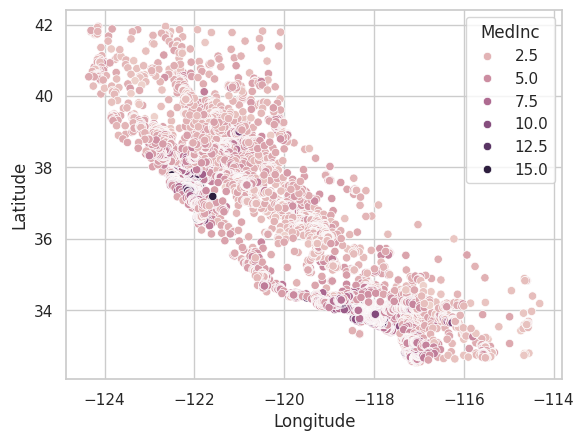

In [69]:
sns.scatterplot(data = total_data, x = 'Longitude', y = 'Latitude', hue = 'MedInc')

In [70]:
total_data.describe()

,MedInc,Latitude,Longitude
count,20640.00,20640.00,20640.00
mean,3.87,35.63,-119.57
std,1.90,2.14,2.00
min,0.50,32.54,-124.35
25%,2.56,33.93,-121.80
50%,3.53,34.26,-118.49
75%,4.74,37.71,-118.01
max,15.00,41.95,-114.31


In [71]:
numerical_columns = [
  "MedInc",  
  "Latitude", 
  "Longitude", 
  ]

for column in numerical_columns:
  stats = total_data[column].describe()
  iqr = stats["75%"] - stats["25%"]
  upper_limit = stats["75%"] + 1.5 * iqr
  lower_limit = stats["75%"] - 1.5 * iqr
  if lower_limit < 0:
    lower_limit = 0
    print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son -112.33 y 0, con un rango intercuartílico de 3.79


In [72]:
total_data_CON_outliers = total_data.copy()

total_data_SIN_outliers = total_data.copy()

def replace_outliers_from_column(column, total_data):
  column_stats = total_data[column].describe()
  column_iqr = column_stats["75%"] - column_stats["25%"]
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  if lower_limit < 0: lower_limit = min(total_data[column])
  total_data[column] = total_data[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  total_data[column] = total_data[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return total_data.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in ['MedInc', 'Longitude', 'Latitude']:
  total_data_SIN_outliers, limit_list = replace_outliers_from_column(column, total_data_SIN_outliers)
  outliers_dict[column] = limit_list

outliers_dict

{'MedInc': [0.4999, np.float64(8.013024999999999)],
 'Longitude': [-124.35, np.float64(-112.32500000000002)],
 'Latitude': [np.float64(28.259999999999998), np.float64(43.38)]}

In [73]:
from sklearn.model_selection import train_test_split

num_variables = ["MedInc", "Longitude", "Latitude"]

X_CON = total_data_CON_outliers
X_train_con_outliers, X_test_con_outliers = train_test_split(X_CON, test_size=0.2, random_state=42)

X_SIN = total_data_SIN_outliers
X_train_sin_outliers, X_test_sin_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 42)

X_train_con_outliers.head()

,MedInc,Latitude,Longitude
14196,3.26,32.71,-117.03
8267,3.81,33.77,-118.16
17445,4.16,34.66,-120.48
14265,1.94,32.69,-117.11
2271,3.55,36.78,-119.80


In [74]:
import numpy as np
from sklearn.cluster import KMeans

for dataset in [
    X_train_con_outliers,
    X_train_sin_outliers,
    ]:
    model = KMeans(n_clusters=6, random_state=42, n_init=10)
    model.fit(dataset)

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scal = scaler.fit_transform(dataset)
X_test_scal  = scaler.transform(dataset)

In [76]:
X_train_sin_outliers["cluster"] = y_train

print(X_train_sin_outliers['cluster'].value_counts())
print(X_train_sin_outliers.head())

cluster
0    4051
2    3814
1    3607
3    2231
5    1475
4    1334
Name: count, dtype: int64
       MedInc  Latitude  Longitude  cluster
14196    3.26     32.71    -117.03        2
8267     3.81     33.77    -118.16        1
17445    4.16     34.66    -120.48        4
14265    1.94     32.69    -117.11        2
2271     3.55     36.78    -119.80        4


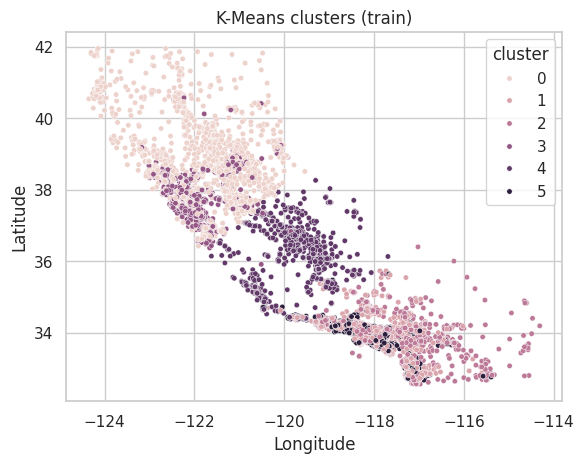

In [80]:
sns.scatterplot(
    data=X_train_sin_outliers,
    x="Longitude", y="Latitude",
    hue="cluster", s=15
)
plt.title("K-Means clusters (train)")
plt.show()

KNN 

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracy_results = []

for dataset in [
    X_train_con_outliers,
    X_train_sin_outliers,
    X_train_scal,
]:
    model = KNeighborsClassifier(
        n_neighbors=5, 
        metric='euclidean', 
        weights='distance',
)
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_results.append(accuracy_score(y_train, y_pred))

print("Accuracy:", accuracy_results)
print("Mejor Accuracy:", max(accuracy_results))


Accuracy: [1.0, 1.0, 1.0]
Mejor Accuracy: 1.0


In [84]:
model = KNeighborsClassifier(
        n_neighbors=5, 
        metric='euclidean', 
        weights='distance',
)
model.fit(X_train_con_outliers, y_train)
y_pred_test = model.predict(X_train_sin_outliers)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy en test:", accuracy)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cluster


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

In [ ]:
cr = classification_report(y_test, y_pred_test)
print("Classificaion report:\n", cr)

rep = classification_report(
    y_test, y_pred_test,
    output_dict=True,
    target_names=["0 (baja)", "1 (media)", "2 (alta)"]
)
total_data = pd.DataFrame(rep).T

heat = total_data.loc[["0 (baja)", "1 (media)", "2 (alta)"], ["precision", "recall", "f1-score"]]

sns.heatmap(heat, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="Blues")
plt.title("Classification Report (heatmap)")
plt.ylabel("Clase"); plt.xlabel("Métrica")
plt.show()

NameError: name 'classification_report' is not defined